In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os

for fname in [
    "phoNER.py",
    "transformer_model.py",
    "train2.py"
]:
  open(f"/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/{fname}", "w").close()

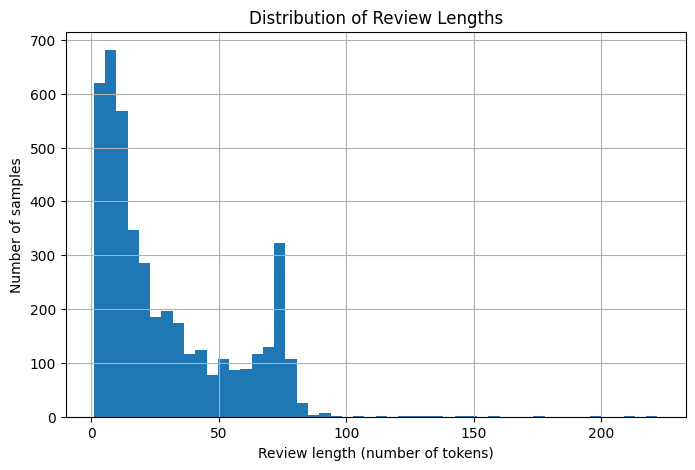

Number of samples: 4387
Min length: 1
Max length: 222
Mean length: 28.759744700250742
Median length: 18.0
95th percentile: 75.0


In [ ]:
import json
import matplotlib.pyplot as plt

# CONFIG
TRAIN_PATH = "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/UIT-ViOCD/train.json"

import json

with open(TRAIN_PATH, "r", encoding="utf-8") as f:
    raw = json.load(f)

# Detect structure
if isinstance(raw, list):
    data = raw
elif isinstance(raw, dict):
    if "data" in raw:
        data = raw["data"]
    else:
        data = list(raw.values())
else:
    raise ValueError("Unsupported JSON format")

# 2. Fake vocab chỉ để tokenize
class DummyVocab:
    def preprocess_sentence(self, s):
        import string
        translator = str.maketrans("", "", string.punctuation)
        return s.lower().translate(translator)

vocab = DummyVocab()

# 3. Tính độ dài từng review
lengths = []

for item in data:
    sentence = item["review"]
    sentence = vocab.preprocess_sentence(sentence)
    tokens = sentence.split()
    lengths.append(len(tokens))

plt.figure(figsize=(8,5))
plt.hist(lengths, bins=50)
plt.xlabel("Review length (number of tokens)")
plt.ylabel("Number of samples")
plt.title("Distribution of Review Lengths")
plt.grid(True)

plt.show()

import numpy as np
lengths = np.array(lengths)

print("Number of samples:", len(lengths))
print("Min length:", lengths.min())
print("Max length:", lengths.max())
print("Mean length:", lengths.mean())
print("Median length:", np.median(lengths))
print("95th percentile:", np.percentile(lengths, 95))


In [3]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py
import torch
from typing import List, Tuple
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
import numpy as np
import json
import os
from torch.nn.utils.rnn import pad_sequence
MAX_LEN = 128

def collate_fn(items):
    input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
    label_ids = [torch.tensor(x["label"][:MAX_LEN]) for x in items]

    # Pad input
    input_ids_padded = pad_sequence(
        input_ids,
        batch_first=True,
        padding_value=0     # <pad> token ID
    )

    # Pad labels
    label_ids_padded = pad_sequence(
        label_ids,
        batch_first=True,
        padding_value=-100  # Giá trị để ignore_index bỏ qua
    )

    # Tạo mask dựa trên input đã pad
    mask = (input_ids_padded != 0).long()
    lengths = mask.sum(dim=1)

    return {
        "input_ids": input_ids_padded,
        "label": label_ids_padded,
        "mask": mask,
        "lengths": lengths
    }

class Vocab:
  def __init__(self, data_files):
    all_words = set()
    tags = set()

    for path in data_files:
        with open(path, encoding="utf-8") as f:
            for line in f:
                sent = json.loads(line.strip())
                tokens = sent["words"]
                labels = sent["tags"]

                all_words.update(tokens)
                tags.update(labels)

    all_words = sorted(all_words)
    self.pad = "<pad>"
    self.unk = "<unk>"

    self.w2i = {word: idx for idx,word in enumerate(all_words, start=2)}
    self.w2i[self.pad] = 0
    self.w2i[self.unk] = 1

    self.i2w = {
        idx: word for word, idx in self.w2i.items()
    }
    tags = sorted(tags)
    self.l2i = {tag: idx for idx, tag in enumerate(tags)}

    self.i2l = {
        idx: tag for tag, idx in self.l2i.items()
    }

  @property
  def len(self):
    return len(self.w2i)

  @property
  def n_labels(self):
    return len(self.l2i)

  def encode_sentence(self,tokens):
    ids = [self.w2i.get(tok, self.w2i[self.unk]) for tok in tokens]
    return torch.tensor(ids).long()

  def encode_labels(self, labels):
    ids = [self.l2i[l] for l in labels]
    return torch.tensor(ids).long()
  def decode_labels(self, id_tensor):
    return [self.i2l[i] for i in id_tensor.tolist()]


class phoNERDataset(Dataset):
  def __init__(self, json_path, vocab:Vocab):
    super().__init__()
    self.vocab = vocab
    self.samples = []

    with open(json_path, encoding="utf-8") as f:
      for line in f:
          sent = json.loads(line.strip())
          tokens = sent["words"]
          labels = sent["tags"]

          x = vocab.encode_sentence(tokens)
          y = vocab.encode_labels(labels)

          self.samples.append({
              "input_ids": x,
              "label": y
          })

  def __len__(self):
    return len(self.samples)

  def __getitem__(self,idx):
    return self.samples[idx]

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py


In [4]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/transformer_model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import math

class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k

    def forward(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Softmax để có attention weights
        attn_weights = F.softmax(scores, dim=-1)

        # Weighted sum của values
        output = torch.matmul(attn_weights, V)

        return output, attn_weights

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Tạo ma trận positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Multi-Head Attention components
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.W_O = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention(self.d_k)

        # Feed-Forward Network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

        # Layer Normalization và Dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()

        # Multi-Head Attention
        Q = self.W_Q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_K(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_V(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Reshape mask cho multi-head attention
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_len)

        # Scaled Dot-Product Attention
        attn_output, _ = self.attention(Q, K, V, mask)

        # Concat heads và linear projection
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        attn_output = self.W_O(attn_output)

        # Add & Norm (Residual connection)
        x = self.norm1(x + self.dropout1(attn_output))

        # Feed-Forward Network
        ffn_output = self.ffn(x)

        # Add & Norm (Residual connection)
        x = self.norm2(x + self.dropout2(ffn_output))

        return x

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoder, self).__init__()

        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x


class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff,
                 num_classes, max_len=128, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.dropout = nn.Dropout(dropout)

        # Token-level classifier
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x, mask=None):
      x = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
      x = self.pos_encoding(x)
      x = self.dropout(x)

      x = self.encoder(x, mask)   # (B, T, D)

      logits = self.fc(x)         # (B, T, num_labels)

      return logits

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/transformer_model.py


In [5]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/train2.py
from phoNER import Vocab, collate_fn, phoNERDataset
from transformer_model import TransformerModel
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

# Hàm huấn luyện
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, mask)

        # Flatten: (B, T, C) -> (B*T, C) và (B, T) -> (B*T)
        flat_logits = logits.view(-1, logits.size(-1))
        flat_labels = labels.view(-1)

        loss = criterion(flat_logits, flat_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(flat_logits, dim=1)

        # Mask lọc bỏ các vị trí là -100
        active_mask = flat_labels != -100

        active_preds = preds[active_mask].cpu().numpy()
        active_labels = flat_labels[active_mask].cpu().numpy()

        predictions.extend(active_preds)
        true_labels.extend(active_labels)

    avg_loss = total_loss / len(dataloader)

    # Tính metric trên dữ liệu thực tế (đã lọc padding)
    accuracy = accuracy_score(true_labels,predictions)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1

# Hàm đánh giá
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, mask)   # (B, T, C)

            # FLATTEN
            loss = criterion(
                logits.view(-1, logits.size(-1)),
                labels.view(-1)
            )

            total_loss += loss.item()

            # predictions
            preds = torch.argmax(logits, dim=-1)   # (B, T)

            valid = labels != -100
            preds = preds[valid].cpu().numpy()
            true = labels[valid].cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(true)

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1, predictions, true_labels

# Hàm vẽ biểu đồ
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training History', fontsize=16, fontweight='bold')

    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
    axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    axes[0, 2].plot(epochs, history['train_precision'], 'b-', label='Train Precision', linewidth=2)
    axes[0, 2].plot(epochs, history['val_precision'], 'r-', label='Val Precision', linewidth=2)
    axes[0, 2].set_title('Precision', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Recall
    axes[1, 0].plot(epochs, history['train_recall'], 'b-', label='Train Recall', linewidth=2)
    axes[1, 0].plot(epochs, history['val_recall'], 'r-', label='Val Recall', linewidth=2)
    axes[1, 0].set_title('Recall', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # F1 Score
    axes[1, 1].plot(epochs, history['train_f1'], 'b-', label='Train F1', linewidth=2)
    axes[1, 1].plot(epochs, history['val_f1'], 'r-', label='Val F1', linewidth=2)
    axes[1, 1].set_title('F1 Score', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Summary text
    axes[1, 2].axis('off')
    best_epoch = np.argmax(history['val_acc']) + 1
    summary_text = f"""
    Training Summary
    ─────────────────────────────
    Total Epochs: {len(epochs)}

    Best Validation Results:
    • Epoch: {best_epoch}
    • Accuracy: {max(history['val_acc']):.4f}
    • Precision: {history['val_precision'][best_epoch-1]:.4f}
    • Recall: {history['val_recall'][best_epoch-1]:.4f}
    • F1 Score: {history['val_f1'][best_epoch-1]:.4f}
    • Loss: {history['val_loss'][best_epoch-1]:.4f}

    Final Results:
    • Train Acc: {history['train_acc'][-1]:.4f}
    • Val Acc: {history['val_acc'][-1]:.4f}
    """
    axes[1, 2].text(0.1, 0.5, summary_text, fontsize=11,
                    verticalalignment='center', family='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    plt.tight_layout()
    plt.show()

# Hàm load checkpoint
def load_checkpoint(checkpoint_path, model, optimizer=None):
    if not os.path.exists(checkpoint_path):
        print(f"⚠️ Không tìm thấy checkpoint tại: {checkpoint_path}")
        return 0, 0.0, 0.0, None

    print(f"Đang load checkpoint từ: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)

    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Đã load model state dict")

    # Load optimizer state
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Đã load optimizer state dict")

    # Lấy thông tin training
    start_epoch = checkpoint.get('epoch', 0)
    best_val_acc = checkpoint.get('val_acc', 0.0)
    best_val_f1 = checkpoint.get('val_f1', 0.0)
    history = checkpoint.get('history', None)

    print(f"\n📋 Thông tin checkpoint:")
    print(f"   • Epoch: {start_epoch}")
    print(f"   • Best Val Accuracy: {best_val_acc:.4f}")
    print(f"   • Best Val F1 Score: {best_val_f1:.4f}")

    if history:
        print(f"   • Đã tìm thấy lịch sử training với {len(history['train_loss'])} epochs")

    return start_epoch, best_val_acc, best_val_f1, history

def check_and_load_checkpoint(checkpoint_path, model, optimizer):
    if os.path.exists(checkpoint_path):
        print(f"\n{'='*60}")
        print(f"Phát hiện checkpoint tại: {checkpoint_path}")
        print(f"{'='*60}")

        checkpoint = torch.load(checkpoint_path)

        print(f"\n📊 Thông tin checkpoint:")
        print(f"   • Epoch: {checkpoint.get('epoch', 'N/A')}")
        print(f"   • Val Accuracy: {checkpoint.get('val_acc', 0.0):.4f}")
        print(f"   • Val F1 Score: {checkpoint.get('val_f1', 0.0):.4f}")

        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        start_epoch = checkpoint.get('epoch', 0)
        best_val_acc = checkpoint.get('val_acc', 0.0)
        best_val_f1 = checkpoint.get('val_f1', 0.0)
        history = checkpoint.get('history', None)

        return start_epoch, best_val_acc, best_val_f1, history

    else:
        print(f"\nKhông tìm thấy checkpoint. Bắt đầu training mới...\n")
        return 0, 0.0, 0.0, None

if __name__ == "__main__":
    D_MODEL = 256
    NUM_LAYERS = 3
    NUM_HEADS = 8
    D_FF = 1024
    DROPOUT = 0.1
    BATCH_SIZE = 32
    MAX_LEN = 128
    EPOCHS = 10
    LEARNING_RATE = 0.0001

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    print("="*60)

    vocab = Vocab(data_files=["/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER/train_syllable.json",
                        "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER/dev_syllable.json",
                        "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER/test_syllable.json"])
    print("Number of labels:", vocab.n_labels)

    train_dataset = phoNERDataset(json_path='/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER/train_syllable.json', vocab=vocab)
    dev_dataset = phoNERDataset(json_path='/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER/dev_syllable.json', vocab=vocab)
    test_dataset = phoNERDataset(json_path='/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER/test_syllable.json', vocab=vocab)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # Khởi tạo mô hình
    print("Khởi tạo mô hình Transformer Encoder (3 lớp)...")

    model = TransformerModel(
        vocab_size=vocab.len,
        d_model=D_MODEL,
        num_layers=NUM_LAYERS,
        num_heads=NUM_HEADS,
        d_ff=D_FF,
        num_classes=vocab.n_labels,
        max_len=MAX_LEN,
        dropout=DROPOUT
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Tổng số tham số: {total_params:,}")
    print(f"Tham số huấn luyện được: {trainable_params:,}")
    print("="*60)

    # Optimizer và Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=-100)

    # Đường dẫn checkpoint
    checkpoint_path = '/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/best_transformer_phoner.pt'

    # Kiểm tra và load checkpoint nếu có
    start_epoch, best_val_acc, best_val_f1, loaded_history = check_and_load_checkpoint(
        checkpoint_path, model, optimizer
    )

    # Lưu trữ lịch sử huấn luyện
    if loaded_history is not None:
        # Tiếp tục từ history cũ
        history = loaded_history
        print(f"Tiếp tục với lịch sử training từ checkpoint")
    else:
        # Bắt đầu history mới
        history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'train_precision': [], 'val_precision': [],
            'train_recall': [], 'val_recall': [],
            'train_f1': [], 'val_f1': []
        }
        print(f"Khởi tạo lịch sử training mới")

    # Huấn luyện
    print("\nBắt đầu huấn luyện...\n")

    for epoch in range(start_epoch, EPOCHS):
        print(f"{'='*60}")
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"{'='*60}")

        # Train
        train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(
            model, train_loader, optimizer, criterion, device
        )

        # Validate
        val_loss, val_acc, val_prec, val_rec, val_f1, val_preds, val_labels = evaluate(
            model, dev_loader, criterion, device
        )

        # Lưu lịch sử
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_precision'].append(train_prec)
        history['val_precision'].append(val_prec)
        history['train_recall'].append(train_rec)
        history['val_recall'].append(val_rec)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        # In kết quả
        print(f"\nTraining Metrics:")
        print(f"   Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Prec: {train_prec:.4f} | Rec: {train_rec:.4f} | F1: {train_f1:.4f}")

        print(f"\nValidation Metrics:")
        print(f"   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")

        # Lưu model tốt nhất
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_f1': val_f1,
                'history': history,  # Lưu cả history
            }, checkpoint_path)
            print(f"\nModel saved! (Best Val Acc: {best_val_acc:.4f}, F1: {best_val_f1:.4f})")

        print()

    print(f"\n{'='*60}")
    print("Hoàn thành huấn luyện!")
    print(f"{'='*60}")
    print(f"\nBest Results:")
    print(f"   Validation Accuracy: {best_val_acc:.4f}")
    print(f"   Validation F1 Score: {best_val_f1:.4f}")

    print(f"{'='*60}")
    print(f"ĐÁNH GIÁ TRÊN TEST")
    test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels = evaluate(
            model, test_loader, criterion, device
        )
    # In classification report chi tiết
    print(f"\n{'='*60}")
    print("Classification Report:")
    print(f"{'='*60}")

    label_ids = sorted(vocab.i2l.keys())
    label_names = [vocab.i2l[i] for i in label_ids]

    print(classification_report(
        test_labels,
        test_preds,
        labels=label_ids,
        target_names=label_names,
        digits=4
    ))

    # Vẽ biểu đồ
    plot_training_history(history)

    print(f"Model đã được lưu tại: {checkpoint_path}")

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/train2.py


Using device: cuda
Number of labels: 21
Khởi tạo mô hình Transformer Encoder (3 lớp)...
Tổng số tham số: 3,841,557
Tham số huấn luyện được: 3,841,557

Không tìm thấy checkpoint. Bắt đầu training mới...

Khởi tạo lịch sử training mới

Bắt đầu huấn luyện...

Epoch 1/10


/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = [torch.tensor(x["label"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive


Training Metrics:
   Loss: 0.9038 | Acc: 0.7814 | Prec: 0.1845 | Rec: 0.0851 | F1: 0.1011

Validation Metrics:
   Loss: 0.7410 | Acc: 0.7903 | Prec: 0.3893 | Rec: 0.2237 | F1: 0.2373

Model saved! (Best Val Acc: 0.7903, F1: 0.2373)

Epoch 2/10


/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = [torch.tensor(x["label"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive


Training Metrics:
   Loss: 0.5371 | Acc: 0.8516 | Prec: 0.3767 | Rec: 0.2517 | F1: 0.2826

Validation Metrics:
   Loss: 0.5553 | Acc: 0.8346 | Prec: 0.3738 | Rec: 0.3224 | F1: 0.3366

Model saved! (Best Val Acc: 0.8346, F1: 0.3366)

Epoch 3/10


/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = [torch.tensor(x["label"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive


Training Metrics:
   Loss: 0.4117 | Acc: 0.8791 | Prec: 0.4718 | Rec: 0.3258 | F1: 0.3539

Validation Metrics:
   Loss: 0.4639 | Acc: 0.8571 | Prec: 0.4828 | Rec: 0.3718 | F1: 0.3997

Model saved! (Best Val Acc: 0.8571, F1: 0.3997)

Epoch 4/10


/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = [torch.tensor(x["label"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive


Training Metrics:
   Loss: 0.3500 | Acc: 0.8921 | Prec: 0.5393 | Rec: 0.3739 | F1: 0.4059

Validation Metrics:
   Loss: 0.4247 | Acc: 0.8660 | Prec: 0.5913 | Rec: 0.4289 | F1: 0.4501

Model saved! (Best Val Acc: 0.8660, F1: 0.4501)

Epoch 5/10


/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = [torch.tensor(x["label"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive


Training Metrics:
   Loss: 0.3081 | Acc: 0.9024 | Prec: 0.5762 | Rec: 0.4128 | F1: 0.4462

Validation Metrics:
   Loss: 0.3894 | Acc: 0.8769 | Prec: 0.6151 | Rec: 0.4373 | F1: 0.4773

Model saved! (Best Val Acc: 0.8769, F1: 0.4773)

Epoch 6/10


/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = [torch.tensor(x["label"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive


Training Metrics:
   Loss: 0.2788 | Acc: 0.9108 | Prec: 0.5908 | Rec: 0.4516 | F1: 0.4889

Validation Metrics:
   Loss: 0.3735 | Acc: 0.8821 | Prec: 0.6125 | Rec: 0.4729 | F1: 0.5115

Model saved! (Best Val Acc: 0.8821, F1: 0.5115)

Epoch 7/10


/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = [torch.tensor(x["label"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive


Training Metrics:
   Loss: 0.2596 | Acc: 0.9164 | Prec: 0.6369 | Rec: 0.4767 | F1: 0.5096

Validation Metrics:
   Loss: 0.3592 | Acc: 0.8850 | Prec: 0.5932 | Rec: 0.5033 | F1: 0.5250

Model saved! (Best Val Acc: 0.8850, F1: 0.5250)

Epoch 8/10


/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = [torch.tensor(x["label"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive


Training Metrics:
   Loss: 0.2372 | Acc: 0.9214 | Prec: 0.6956 | Rec: 0.5008 | F1: 0.5366

Validation Metrics:
   Loss: 0.3358 | Acc: 0.8927 | Prec: 0.7063 | Rec: 0.5126 | F1: 0.5458

Model saved! (Best Val Acc: 0.8927, F1: 0.5458)

Epoch 9/10


/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = [torch.tensor(x["label"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive


Training Metrics:
   Loss: 0.2223 | Acc: 0.9260 | Prec: 0.6887 | Rec: 0.5258 | F1: 0.5656

Validation Metrics:
   Loss: 0.3290 | Acc: 0.8938 | Prec: 0.7127 | Rec: 0.5289 | F1: 0.5570

Model saved! (Best Val Acc: 0.8938, F1: 0.5570)

Epoch 10/10


/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = [torch.tensor(x["label"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive


Training Metrics:
   Loss: 0.2089 | Acc: 0.9305 | Prec: 0.6842 | Rec: 0.5393 | F1: 0.5758

Validation Metrics:
   Loss: 0.3216 | Acc: 0.8960 | Prec: 0.7231 | Rec: 0.5351 | F1: 0.5727

Model saved! (Best Val Acc: 0.8960, F1: 0.5727)


Hoàn thành huấn luyện!

Best Results:
   Validation Accuracy: 0.8960
   Validation F1 Score: 0.5727
ĐÁNH GIÁ TRÊN TEST


/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(x["input_ids"][:MAX_LEN]) for x in items]
/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/phoNER.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_ids = [torch.tensor(x["label"][:MAX_LEN]) for x in items]



Classification Report:
                       precision    recall  f1-score   support

                B-AGE     0.7064    0.5546    0.6214       577
               B-DATE     0.7733    0.7729    0.7731      1651
             B-GENDER     0.9085    0.8468    0.8766       457
                B-JOB     0.7660    0.2081    0.3273       173
           B-LOCATION     0.7403    0.6727    0.7049      4436
               B-NAME     0.7593    0.2579    0.3850       318
       B-ORGANIZATION     0.7060    0.7134    0.7097       771
         B-PATIENT_ID     0.7021    0.7373    0.7193      1995
B-SYMPTOM_AND_DISEASE     0.8662    0.7121    0.7816      1136
     B-TRANSPORTATION     0.8265    0.4197    0.5567       193
                I-AGE     0.0000    0.0000    0.0000         6
               I-DATE     0.7131    0.8671    0.7826      1746
             I-GENDER     0.0000    0.0000    0.0000         1
                I-JOB     0.6111    0.2219    0.3256       347
           I-LOCATION     0.77

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


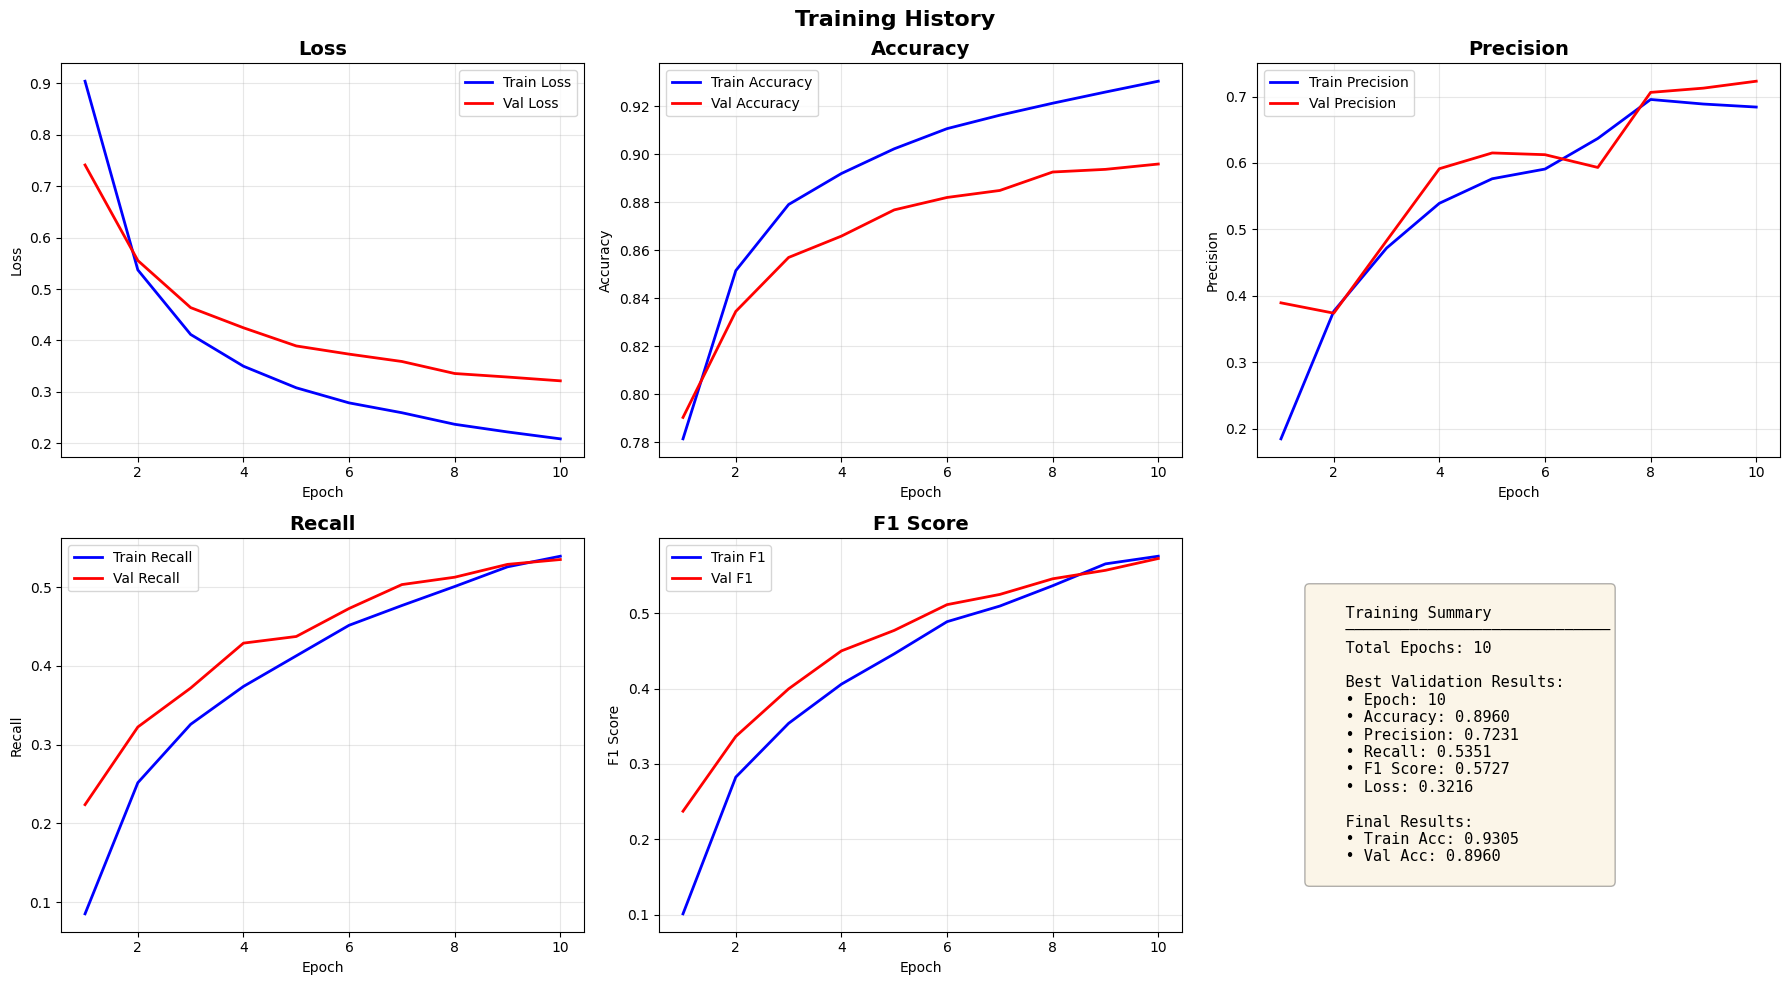

Model đã được lưu tại: /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/best_transformer_phoner.pt


<Figure size 640x480 with 0 Axes>

In [6]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/train2.py')
%run /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB5/train2.py